In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, rdMolDescriptors

In [85]:
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99,  (1, 7): 93,  (1, 8): 111, (1, 9): 135,
    (6, 6): 83,  (6, 7): 73,  (6, 8): 86,  (6, 9): 116,
    (7, 7): 39,  (7, 8): 53,  (8, 8): 35
}

# 2. H5 파일 키 설정
KEY_CONFIG = {
    "atoms": "elements", 
    "smiles": "Rsmiles",
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 3. 원자 매핑 (Dataset 내부에서 사용됨)
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

In [105]:
class RDKitEnhancedDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(RDKitEnhancedDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get_rdkit_atom_features(self, mol):
        """
        RDKit Mol 객체에서 물리/화학적 특징을 완벽하게 추출
        """
        # 1. Gasteiger Charge 계산
        try:
            AllChem.ComputeGasteigerCharges(mol)
        except:
            pass # 계산 실패 시 0.0으로 처리됨
        
        features = []
        
        # Atom Map Number 순서대로 정렬
        atoms_with_map = []
        for atom in mol.GetAtoms():
            map_num = atom.GetAtomMapNum()
            if map_num == 0: map_num = atom.GetIdx() + 1
            atoms_with_map.append((map_num, atom))
        
        atoms_with_map.sort(key=lambda x: x[0])
        
        for _, atom in atoms_with_map:
            feat = []
            
            # [1] Atomic Number (One-hot) - 6 dim
            symbol = atom.GetSymbol()
            sym_map = {'H':0, 'C':1, 'N':2, 'O':3, 'F':4}
            one_hot = [0] * 6
            one_hot[sym_map.get(symbol, 5)] = 1
            feat.extend(one_hot)
            
            # [2] Hybridization (One-hot) - 5 dim [수정됨!]
            hyb = atom.GetHybridization()
            hyb_map = {
                rdchem.HybridizationType.SP: 0,
                rdchem.HybridizationType.SP2: 1,
                rdchem.HybridizationType.SP3: 2,
                rdchem.HybridizationType.SP3D: 3,
                rdchem.HybridizationType.SP3D2: 4
            }
            # AROMATIC 키를 삭제하고, 매핑되지 않는 값(UNSPECIFIED 등)은 모두 0으로 처리
            hyb_vec = [0] * 5
            if hyb in hyb_map:
                hyb_vec[hyb_map[hyb]] = 1
            feat.extend(hyb_vec)
            
            # [3] Electronic Properties - 4 dim
            try:
                charge = float(atom.GetProp('_GasteigerCharge'))
                if np.isnan(charge) or np.isinf(charge): charge = 0.0
            except:
                charge = 0.0
            
            formal_q = float(atom.GetFormalCharge())
            n_valence = float(atom.GetTotalValence())
            mass = atom.GetMass() / 20.0
            
            feat.extend([charge, formal_q, n_valence, mass])
            
            # [4] Ring Topology - 4 dim
            in_3 = 1.0 if atom.IsInRingSize(3) else 0.0
            in_4 = 1.0 if atom.IsInRingSize(4) else 0.0
            in_5 = 1.0 if atom.IsInRingSize(5) else 0.0
            in_6 = 1.0 if atom.IsInRingSize(6) else 0.0
            feat.extend([in_3, in_4, in_5, in_6])
            
            # [5] Aromaticity & Chirality - 2 dim
            is_arom = 1.0 if atom.GetIsAromatic() else 0.0
            chiral = 1.0 if atom.GetChiralTag() != rdchem.ChiralType.CHI_UNSPECIFIED else 0.0
            feat.extend([is_arom, chiral])
            
            features.append(feat)
            
        return torch.tensor(features, dtype=torch.float)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            
            if KEY_CONFIG["smiles"] in group:
                smi_bytes = group[KEY_CONFIG["smiles"]][()]
                smiles = smi_bytes.decode('utf-8') if isinstance(smi_bytes, bytes) else str(smi_bytes)
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol = Chem.AddHs(mol)
                    x = self.get_rdkit_atom_features(mol)
                else:
                    # SMILES 파싱 실패 시 더미 데이터
                    # (실제 데이터셋에 이런 경우가 드물게 있을 수 있음)
                    atoms = group[KEY_CONFIG["atoms"]][()]
                    x = torch.zeros(len(atoms), 21) 
            else:
                raise ValueError("SMILES data is missing.")

            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            thermo_energy = e_P - e_R
            y_activation = e_TS - e_R
            
            # 크기 불일치 방지 (SMILES와 좌표 개수가 다를 경우)
            if x.size(0) != pos_R.size(0):
                min_len = min(x.size(0), pos_R.size(0))
                x = x[:min_len]
                pos_R = pos_R[:min_len]
                pos_P = pos_P[:min_len]
                pos_TS = pos_TS[:min_len]

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)
            
            # BDE용 Z (원자번호) 복원
            sym_idx = torch.argmax(x[:, :6], dim=1)
            idx_to_z = {0:1, 1:6, 2:7, 3:8, 4:9, 5:0}
            z_values = torch.tensor([idx_to_z.get(i.item(), 0) for i in sym_idx], dtype=torch.long)
            
            edge_bde = []
            for r, c in edge_index.T:
                pair = tuple(sorted((int(z_values[r]), int(z_values[c]))))
                edge_bde.append(BDE_TABLE.get(pair, 80.0))
            edge_bde = torch.tensor(edge_bde, dtype=torch.float).unsqueeze(-1)

            return Data(x=x, z=z_values, 
                        pos=pos_R, pos_P=pos_P, edge_index=edge_index, 
                        y_energy=y_activation, y_pos=pos_TS, 
                        thermo_energy=thermo_energy, edge_bde=edge_bde)

In [106]:
class RDKitEnergyModel(nn.Module):
    def __init__(self, node_dim=21, hidden_dim=256, num_layers=4):
        super().__init__()
        # 1. Encoder (DeepGCPNet)
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers) 
        
        # 2. Gating & Decoder
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        
        # 3. Predictor (기존 StereoElectronicPredictor 재사용)
        # 단, 내부 입력 차원 계산은 자동화됨
        self.energy_predictor = StereoElectronicPredictor(hidden_dim)

    def forward(self, data):
        # x는 이제 21차원의 풍부한 RDKit 정보를 담고 있음
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # HSAB 정보 추출 (x 텐서의 11번째(Gasteiger), 12번째(Formal) 등을 사용)
        # x구조: [AtomOneHot(6), Hyb(5), Charge(1), Formal(1), Val(1), Mass(1), Rings(4), Arom(1), Chir(1)]
        # Charge index: 11, Hardness(대신 Valence 등 사용)
        # 간편하게 x의 일부를 잘라서 사용하거나, 기존처럼 별도 텐서를 안 써도 됨
        # Predictor에 필요한 추가 정보들은 h에 이미 인코딩되어 있다고 가정하고
        # 명시적인 z, hsab 인자 대신 h를 강화하여 전달
        
        # 호환성을 위해 더미 데이터 생성 (필요시)
        dummy_hsab = torch.zeros(h.size(0), 2, device=h.device) # Placeholder
        dummy_bde = torch.ones(data.edge_index.size(1), 1, device=h.device)

        pred_delta_E3 = self.energy_predictor(
            h, data.z, dummy_hsab, data.edge_index, data.pos, data.pos_P, 
            gate_map, pred_delta_D, data.batch, 
            data.thermo_energy, dummy_bde
        )
        return pred_delta_D, pred_delta_E3, gate_map

In [107]:
class HOMALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.cc_opt = 1.388
        self.cc_alpha = 257.7
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        is_cc = (z[row] == 6) & (z[col] == 6)
        diff = dist - self.cc_opt
        penalty = self.cc_alpha * (diff ** 2)
        homa = torch.where(is_cc.unsqueeze(-1), 1.0 - penalty, torch.zeros_like(dist))
        return torch.clamp(homa, -1.0, 1.0)

In [108]:
class ElectrostaticsLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, charge, edge_index, dist):
        row, col = edge_index
        q_i = charge[row]
        q_j = charge[col]
        # 결과: [E, 1]
        return (q_i * q_j) / (dist + 0.1)

In [109]:
class SolvationLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, h, batch):
        mol_feat = global_add_pool(h, batch)
        effective_q2 = torch.norm(mol_feat, dim=-1, keepdim=True) ** 2
        mol_size = global_add_pool(torch.ones_like(batch, dtype=torch.float).unsqueeze(-1), batch)
        return -1.0 * (effective_q2 / (mol_size + 1.0))

In [110]:
class StereoPhysicsDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(StereoPhysicsDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get_bde(self, z1, z2):
        pair = tuple(sorted((int(z1), int(z2))))
        return BDE_TABLE.get(pair, 80.0)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            atoms = group[KEY_CONFIG["atoms"]][()]
            z_values = torch.tensor([int(a) for a in atoms], dtype=torch.long)
            
            # [수정됨] x, hsab, en 모두 생성
            x_list = []
            hsab_list = [] 
            en_list = [] # 전기음성도 따로 저장 (ElectrostaticsLayer용)
            
            for z in z_values:
                z_int = int(z.item())
                one_hot = [0]*5
                one_hot[ATOM_MAP.get(z_int, 0)] = 1
                
                # [EN, Hardness, Radius]
                props = ATOM_PHYSICS.get(z_int, [0,0,0]) 
                
                x_list.append(one_hot + props)
                
                # HSAB: [Chemical Potential(-EN), Hardness]
                hsab_list.append([-props[0], props[1]])
                
                # EN: [Electronegativity]
                en_list.append([props[0]]) 
            
            x = torch.tensor(x_list, dtype=torch.float)
            hsab = torch.tensor(hsab_list, dtype=torch.float)
            en = torch.tensor(en_list, dtype=torch.float) # 텐서 변환

            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            thermo_energy = e_P - e_R
            y_activation = e_TS - e_R

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)
            
            bde_feat = []
            for r, c in edge_index.T:
                bde_feat.append(self.get_bde(z_values[r], z_values[c]))
            bde_feat = torch.tensor(bde_feat, dtype=torch.float).unsqueeze(-1)

            # Return에 en=en 추가됨
            return Data(x=x, z=z_values, hsab=hsab, en=en, 
                        pos=pos_R, edge_index=edge_index, 
                        y_energy=y_activation, y_pos=pos_TS, 
                        pos_P=pos_P, thermo_energy=thermo_energy,
                        edge_bde=bde_feat)

In [111]:
class StereoelectronicLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        vec_R = F.normalize(pos_R[col] - pos_R[row], p=2, dim=-1)
        vec_P = F.normalize(pos_P[col] - pos_P[row], p=2, dim=-1)
        alignment = (vec_R * vec_P).sum(dim=-1, keepdim=True)
        return alignment

In [112]:
class HSABInteractionLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, mu, eta, edge_index):
        row, col = edge_index
        # mu: Chemical Potential [N, 1]
        # eta: Hardness [N, 1]
        
        # 브로드캐스팅을 위해 차원이 이미 [E, 1]로 맞춰져 있음
        d_mu = (mu[row] - mu[col]).pow(2)
        sum_eta = eta[row] + eta[col]
        
        # [수정됨] .unsqueeze(-1) 제거! 
        # 이미 2차원이므로 그대로 반환해야 [E, 1] 형태가 유지됨
        return (d_mu / (sum_eta + 1e-6))

In [113]:
class StericLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1) # [E]
        density = 1.0 / (dist.pow(2) + 0.1)
        steric = torch.zeros(pos.size(0), 1, device=pos.device)
        steric.index_add_(0, row, density.unsqueeze(-1)) # [N, 1]
        return steric

In [114]:
class PaulingBondLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1) # [E, 1]
        return torch.exp((r0_sum - dist) / 0.3)

In [115]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(node_dim, hidden_dim)
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [116]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, self.message_mlp(edge_feat))
        return self.norm(h + self.update_mlp(torch.cat([h, aggr_msg], dim=-1)))

In [117]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(nn.Linear(hidden_dim*2+1, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1), nn.Sigmoid())
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row]-pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [118]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

In [119]:
class UniversalPhysicsPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        # 모든 물리 레이어 장착
        self.steric = StericLayer()
        self.pauling = PaulingBondLayer()
        self.stereo = StereoelectronicLayer()
        self.electro = ElectrostaticsLayer()
        self.hsab = HSABInteractionLayer()
        self.solvation = SolvationLayer()
        self.homa = HOMALayer()
        
        # Node MLP (Base Energy)
        # Hidden + Thermo(3) + Steric(1) + Solv(1)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3 + 1 + 1, hidden_dim), 
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP (Barrier Energy)
        # Features:
        # Hidden(2*H) + Dist(1) + PredD(1) + Gate(1) + BO_R(1) + BO_P(1) + dBO(1) 
        # + BDE(1) + Break(1) + Form(1) + Alignment(1) + Coulomb(1) + HSAB(1) + HOMA(1)
        # Total = 2*H + 13 features
        edge_in = (hidden_dim * 2) + 13
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, z, charge, mu, eta, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy, edge_bde):
        """
        h: GNN Node Feature
        z: Atomic Number
        charge: Gasteiger Partial Charge (from RDKit)
        mu: Chemical Potential (from EN)
        eta: Chemical Hardness
        """
        row, col = edge_index
        
        # --- 1. Node Level Physics ---
        steric_R = self.steric(pos_R, edge_index)
        solv_E = self.solvation(h, batch)
        
        h_graph = global_add_pool(h, batch)
        steric_graph = global_add_pool(steric_R, batch)
        
        base_feat = torch.cat([h_graph, thermo_energy, steric_graph, solv_E], dim=-1)
        base_energy = self.node_mlp(base_feat)
        
        # --- 2. Edge Level Physics ---
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # Pauling Bond Order
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        d_bo = bo_P - bo_R
        
        # Hammond (Bond Breaking/Forming)
        is_bond_R = torch.sigmoid(10.0 * (2.0 - dist_R))
        is_bond_P = torch.sigmoid(10.0 * (2.0 - dist_P))
        breaking = is_bond_R * (1 - is_bond_P)
        forming = (1 - is_bond_R) * is_bond_P
        
        # Stereoelectronics (Alignment)
        align = self.stereo(pos_R, pos_P, edge_index)
        
        # Electrostatics (Coulomb using RDKit Charge)
        coulomb = self.electro(charge, edge_index, dist_R)
        
        # HSAB Interaction
        hsab_E = self.hsab(mu, eta, edge_index)
        
        # HOMA (Aromaticity)
        homa_R = self.homa(z, edge_index, dist_R)
        
        # --- 3. Assemble & Predict ---
        edge_feat = torch.cat([
            h[row], h[col], 
            dist_R, pred_delta_D, gate_score,
            bo_R, bo_P, d_bo, 
            edge_bde, 
            breaking, forming, 
            align, coulomb, hsab_E, homa_R
        ], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

In [120]:
class StereoElectronicPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.pauling = PaulingBondLayer()
        self.steric = StericLayer()
        self.stereo = StereoelectronicLayer() # New
        self.hsab = HSABInteractionLayer()   # New
        
        # Node MLP
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3 + 1, hidden_dim), 
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP
        # Features: Hidden(2)*256 + Dist(1) + PredD(1) + Gate(1) + BO_R(1) + BO_P(1) + dBO(1) 
        #           + BDE(1) + Break(1) + Form(1) + Alignment(1) + FMO(1)
        # Total: 512 + 11 = 523
        edge_in = (hidden_dim * 2) + 11
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy, edge_bde):
        row, col = edge_index
        
        # 1. Node Level Physics
        steric_R = self.steric(pos_R, edge_index)
        h_graph = global_add_pool(h, batch)
        steric_graph = global_add_pool(steric_R, batch)
        base_feat = torch.cat([h_graph, thermo_energy, steric_graph], dim=-1)
        base_energy = self.node_mlp(base_feat)
        
        # 2. Edge Level Physics
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # Pauling BO
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        delta_bo = bo_P - bo_R
        
        # Hammond (Bond Change)
        is_bond_R = torch.sigmoid(10.0 * (2.0 - dist_R))
        is_bond_P = torch.sigmoid(10.0 * (2.0 - dist_P))
        bond_breaking = is_bond_R * (1 - is_bond_P)
        bond_forming = (1 - is_bond_R) * is_bond_P
        
        # [New] Stereoelectronic Alignment (Vector Angle Change)
        alignment = self.stereo(pos_R, pos_P, edge_index)
        
        # [New] HSAB / FMO Interaction
        fmo_energy = self.hsab(hsab, edge_index)
        
        # 3. Feature Assembly
        edge_feat = torch.cat([
            h[row], h[col], 
            dist_R, pred_delta_D, gate_score,
            bo_R, bo_P, delta_bo, 
            edge_bde, 
            bond_breaking, bond_forming, # Hammond
            alignment, # Stereoelectronics
            fmo_energy # HSAB
        ], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

In [121]:
class RDKitEnergyModel(nn.Module):
    def __init__(self, node_dim=21, hidden_dim=256, num_layers=4):
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        
        # 방금 만든 통합 예측기 사용
        self.energy_predictor = UniversalPhysicsPredictor(hidden_dim)
        
        # Hardness(Eta)와 Mu(Chemical Potential)는 RDKit에 없으므로 
        # 임베딩으로 학습하거나 기존 Table을 Lookup 해야 함.
        # 여기서는 모델 내부에 Lookup Table을 내장하여 처리 (편의성)
        # H, C, N, O, F 순서 (인덱스 0~4)
        self.atom_props = nn.Parameter(torch.tensor([
            [2.20, 6.42],  # H: [EN, Hardness]
            [2.55, 5.00],  # C
            [3.04, 7.27],  # N
            [3.44, 6.08],  # O
            [3.98, 7.01]   # F
        ]), requires_grad=False) # 고정값

    def forward(self, data):
        # 1. GNN Encoder
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # 2. RDKit Feature Unpacking
        # data.x 구조: [Sym(6), Hyb(5), Charge(1), Formal(1), Val(1), Mass(1), Rings(4), Arom(1), Chir(1)]
        
        # (1) Atomic Number (z) 복원: 앞의 6개(One-hot) 중 argmax
        # 0:H, 1:C, 2:N, 3:O, 4:F, 5:Other
        sym_idx = torch.argmax(data.x[:, :6], dim=1)
        idx_to_z = torch.tensor([1, 6, 7, 8, 9, 0], device=data.x.device)
        z = idx_to_z[sym_idx]
        
        # (2) Gasteiger Charge (인덱스 11)
        charge = data.x[:, 11].unsqueeze(-1)
        
        # (3) HSAB Params (Mu, Eta) Lookup
        # sym_idx가 5(Other)인 경우 0으로 처리하기 위해 clamp
        safe_idx = torch.clamp(sym_idx, 0, 4)
        props = self.atom_props[safe_idx] # (N, 2)
        mu = -props[:, 0].unsqueeze(-1)   # Chemical Potential = -EN
        eta = props[:, 1].unsqueeze(-1)   # Hardness
        
        # 3. Predict Energy
        pred_delta_E3 = self.energy_predictor(
            h, z, charge, mu, eta,
            data.edge_index, data.pos, data.pos_P, 
            gate_map, pred_delta_D, data.batch, 
            data.thermo_energy, data.edge_bde
        )
        
        return pred_delta_D, pred_delta_E3, gate_map

In [122]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # 1. RDKit Dataset
    dataset = RDKitEnhancedDataset(h5_path, limit=limit)
    
    # 통계 계산
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5
    for b in loader_stat:
        all_E.append(b.y_energy.view(-1, 3) * HARTREE_TO_KCAL)
    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Stats -> Mean: {y_mean.cpu().numpy()}")

    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 2. 모델 생성 (Node Dim = 21)
    model = RDKitEnergyModel(node_dim=21, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start RDKit-Native Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            batch.thermo_energy = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL
            
            # Forward
            pred_d, pred_e3, gate = model(batch)
            
            # Targets
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            e_target_kcal = batch.y_energy.view(-1, 3) * HARTREE_TO_KCAL
            e_target_norm = (e_target_kcal - y_mean) / y_std
            
            loss_struct = F.smooth_l1_loss(pred_d, dist_TS - dist_R)
            loss_energy = F.smooth_l1_loss(pred_e3, e_target_norm)
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            if epoch == epochs - 1:
                r = e_target_kcal.detach().cpu().numpy()
                p = (pred_e3.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        avg_loss = epoch_loss / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)

    return history, real_E3, pred_E3

Device: cpu
Computing stats...
Stats -> Mean: [69.403175 74.3915   72.29167 ]

[Start RDKit-Native Training]


Epoch 40/40: 100%|███████████████████████████████████████████████████| 313/313 [03:59<00:00,  1.31batch/s, Loss=1.1163]


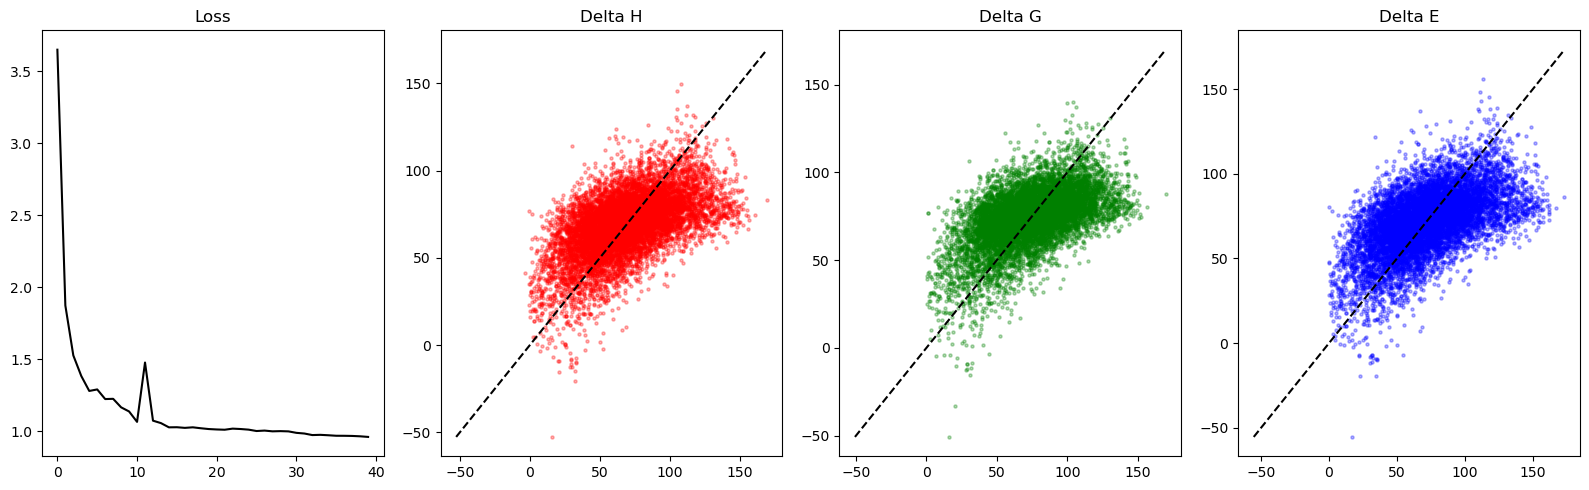

In [123]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\ansh1\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [124]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 18.4356    | 23.3795    | 546.5988   | 0.3125    
Delta G (ΔG)    | 17.8277    | 22.2760    | 496.2217   | 0.2965    
Delta E (ΔE)    | 19.0653    | 24.2486    | 587.9946   | 0.3148    
⭐ Average MAE: 18.4429 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

